# Question 9.1

In [20]:
from json import loads
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime

tweet_directory = './ECE219_tweet_data/'

statistics = []

# process each hashtag file
for file in os.listdir(tweet_directory):
    hashtag_name = file.split('.')[0].split('_')[1]

    # initializing
    total_followers = 0
    total_retweets = 0
    tweet_count = 0
    tweets_per_hour = defaultdict(int)

    earliest_time = float('inf')
    latest_time = float('-inf')

    with open(os.path.join(tweet_directory, file), encoding="utf8") as tweet_file:
        for line in tweet_file:
            tweet_data = loads(line.strip())

            followers_count = tweet_data['author']['followers']
            retweets_count = tweet_data['metrics']['citations']['total']
            tweet_time = tweet_data['citation_date']

            # convert to hourly timestamp
            timestamp = datetime.datetime.fromtimestamp(tweet_time)
            hourly_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

            total_followers += followers_count
            total_retweets += retweets_count
            tweets_per_hour[hourly_timestamp] += 1
            tweet_count += 1

            # track earliest and latest tweet timestamps
            earliest_time = min(earliest_time, tweet_time)
            latest_time = max(latest_time, tweet_time)

    # compute total hours in the dataset (including empty hours)
    total_hours = (latest_time - earliest_time) / 3600
    avg_tweets_per_hour = tweet_count / total_hours if total_hours else 0
    avg_followers_per_tweet = total_followers / tweet_count if tweet_count else 0
    avg_retweets_per_tweet = total_retweets / tweet_count if tweet_count else 0

    statistics.append({
        "Hashtag": hashtag_name,
        "Avg Tweets per Hour": avg_tweets_per_hour,
        "Avg Followers per Tweet": avg_followers_per_tweet,
        "Avg Retweets per Tweet": avg_retweets_per_tweet
    })

df_statistics = pd.DataFrame(statistics)
df_statistics.set_index("Hashtag", inplace=True)

# descending order based on Avg Tweets per Hour
df_statistics = df_statistics.sort_values(by="Avg Tweets per Hour", ascending=False)

# Display results
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.float_format', '{:.4f}'.format)  

print(df_statistics)

             Avg Tweets per Hour  Avg Followers per Tweet  Avg Retweets per Tweet
Hashtag                                                                          
#superbowl             2072.1184                8814.9680                  2.3912
#sb49                  1276.8571               10374.1603                  2.5271
#patriots               750.8943                3280.4636                  1.7853
#nfl                    397.0214                4662.3754                  1.5345
#gohawks                292.4879                2217.9237                  2.0132
#gopatriots              40.9547                1427.2526                  1.4082


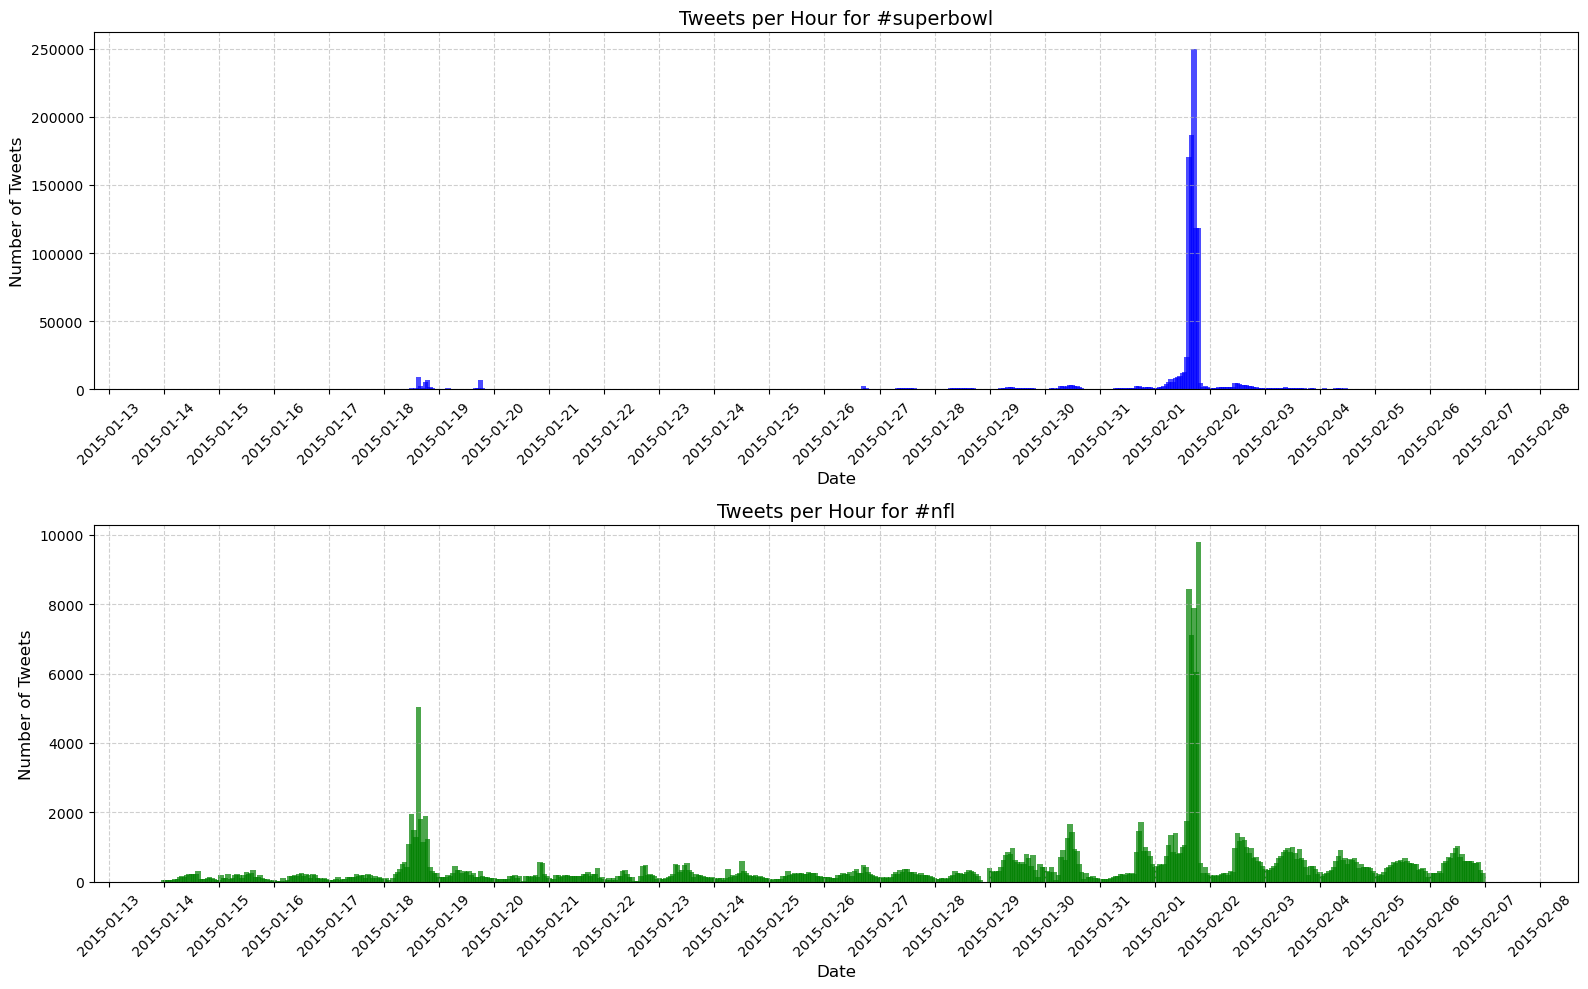

In [21]:
from json import loads
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tweet_directory = './ECE219_tweet_data/'

def process_hashtag_file(file):
    hashtag_name = file.split('.')[0].split('_')[1]
    tweets_per_hour = defaultdict(int)

    with open(os.path.join(tweet_directory, file), encoding="utf8") as tweet_file:
        for line in tweet_file:
            tweet_data = loads(line.strip())
            tweet_time = tweet_data['citation_date']

            # convert to hourly timestamp
            timestamp = datetime.datetime.fromtimestamp(tweet_time)
            hourly_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

            tweets_per_hour[hourly_timestamp] += 1

    return hashtag_name, tweets_per_hour

superbowl_file = 'tweets_#superbowl.txt'
nfl_file = 'tweets_#nfl.txt'

superbowl_hashtag, superbowl_tweets_per_hour = process_hashtag_file(superbowl_file)
nfl_hashtag, nfl_tweets_per_hour = process_hashtag_file(nfl_file)

# converting to defaultdict to a dataframe to make plotting easier
superbowl_df = pd.DataFrame(list(superbowl_tweets_per_hour.items()), columns=['Time', 'Tweets'])
nfl_df = pd.DataFrame(list(nfl_tweets_per_hour.items()), columns=['Time', 'Tweets'])

# sort the dataframes by time
superbowl_df = superbowl_df.sort_values(by='Time')
nfl_df = nfl_df.sort_values(by='Time')

# plot data
plt.figure(figsize=(16, 10)) 

# plot for #superbowl
plt.subplot(2, 1, 1)
plt.bar(superbowl_df['Time'], superbowl_df['Tweets'], color='blue', alpha=0.7, width=0.1)  # Increased bar width
plt.title(f'Tweets per Hour for {superbowl_hashtag}', fontsize=14)
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Number of Tweets', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# showing by date since labeling by hour is too hard to read
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.xticks(rotation=45)  

# plot for #nfl
plt.subplot(2, 1, 2)
plt.bar(nfl_df['Time'], nfl_df['Tweets'], color='green', alpha=0.7, width=0.1) 
plt.title(f'Tweets per Hour for {nfl_hashtag}', fontsize=14)
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Number of Tweets', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# formatting for date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

# Question 10

In [22]:
from json import loads
import pandas as pd
import datetime
import pytz  # For timezone conversion

# Define the file path
file_path = './ECE219_tweet_data/tweets_#gopatriots.txt'

# Initialize a list to store tweet data
tweet_data_list = []

# Open the file and process each line
with open(file_path, encoding="utf8") as tweet_file:
    for line in tweet_file:
        try:
            tweet_data = loads(line.strip())

            # Extract relevant fields with error handling
            followers_count = tweet_data.get('author', {}).get('followers', 0)
            retweets_count = tweet_data.get('metrics', {}).get('citations', {}).get('total', 0)
            tweet_time = tweet_data.get('citation_date', None)
            tweet_text = tweet_data.get('title', "")  # 'title' holds tweet text, not 'text'!
            hashtags_list = tweet_data.get("tweet", {}).get("entities", {}).get("hashtags", [])

            # Extract hashtags from entities (if available)
            hashtags = [tag['text'].lower() for tag in hashtags_list]  # Convert to lowercase

            # Skip tweets with missing timestamp
            if tweet_time is None:
                continue

            # Convert to datetime object and adjust to Pacific Time
            pst_timezone = pytz.timezone('America/Los_Angeles')
            timestamp = datetime.datetime.fromtimestamp(tweet_time, pst_timezone)

            # Store tweet data for further analysis
            tweet_data_list.append({
                "Hashtag": "#gopatriots",  # Hardcoded since we're only processing this file
                "Text": tweet_text,
                "Timestamp": timestamp,
                "Retweets": retweets_count,
                "Followers": followers_count,
                "Hashtags": hashtags
            })

        except Exception as e:
            print(f"Error processing tweet: {e}")
            continue  # Skip invalid lines

# Convert the list of tweet data to a DataFrame
df_tweets = pd.DataFrame(tweet_data_list)

# Display sample tweet data
print("Sample Tweet Data:")
print(df_tweets.head())

# Explore the dataset
print("\nHashtag Distribution:")
print(df_tweets['Hashtag'].value_counts())

print("\nEngagement Metrics Summary:")
print(df_tweets[['Retweets', 'Followers']].describe())

# Display dataset info at the end
print("\nDataset Info:")
print(df_tweets.info())


Sample Tweet Data:
       Hashtag                                               Text                 Timestamp  Retweets  Followers                                           Hashtags
0  #gopatriots  LeGarrette Blount does the Ray Lewis Dance #Th... 2015-01-14 09:45:41-08:00         6  2895.0000                    [throwbackthursday, gopatriots]
1  #gopatriots  Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M... 2015-01-14 14:44:31-08:00         4   158.0000                          [gopatriots, myfutureson]
2  #gopatriots  With both my father and husband yelling at the... 2015-01-15 09:11:15-08:00         3 20896.0000  [gopatriots, football, patriots, newengland, yay]
3  #gopatriots  The girls soccer team is ranked the No. 3 team... 2015-01-14 17:26:29-08:00         3   500.0000                                       [gopatriots]
4  #gopatriots  @patriots Patriots Champions! RT if you agree ... 2015-01-16 08:55:32-08:00         2   491.0000                                       [gopatriot

<Axes: title={'center': 'Top 20 Hashtags'}, xlabel='Hashtag'>

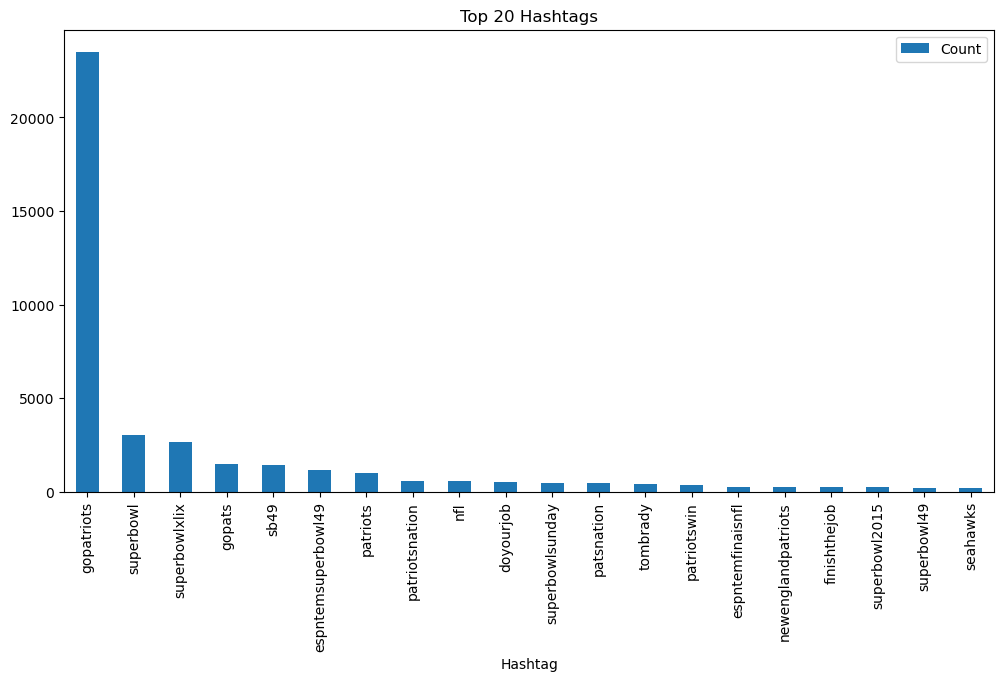

In [23]:
from collections import Counter

# Flatten all hashtag lists and count occurrences
all_hashtags = [tag for tags in df_tweets["Hashtags"] for tag in tags]
hashtag_counts = Counter(all_hashtags).most_common(20)  # Top 20 hashtags

# Convert to DataFrame for plotting
df_hashtags = pd.DataFrame(hashtag_counts, columns=["Hashtag", "Count"])
df_hashtags.plot(kind="bar", x="Hashtag", y="Count", figsize=(12, 6), title="Top 20 Hashtags")


<Axes: title={'center': 'Tweet Volume by Hour'}, xlabel='Hour'>

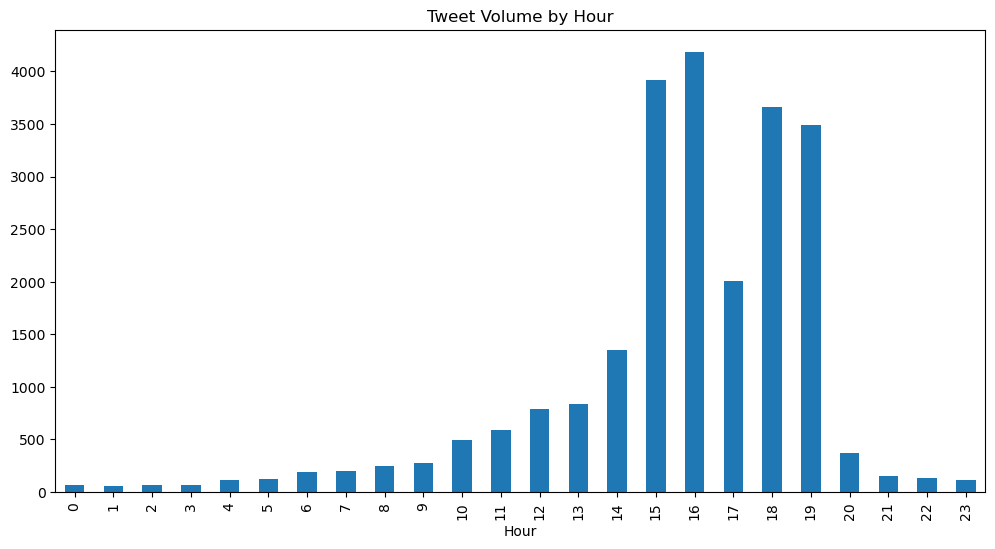

In [24]:
df_tweets["Hour"] = df_tweets["Timestamp"].dt.hour  # Extract hour of day
df_tweets.groupby("Hour").size().plot(kind="bar", figsize=(12, 6), title="Tweet Volume by Hour")


<Axes: xlabel='Hashtag_Count', ylabel='Retweets'>

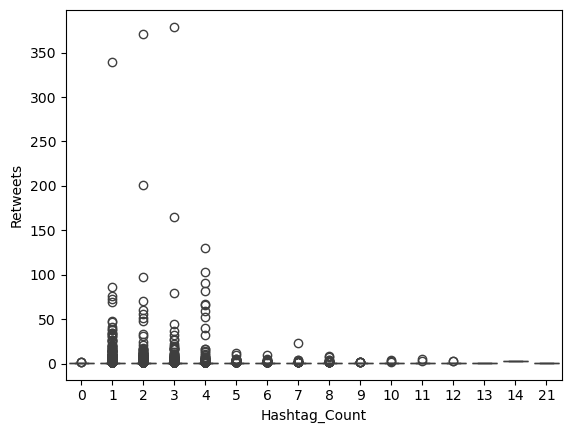

In [25]:
import seaborn as sns

df_tweets["Hashtag_Count"] = df_tweets["Hashtags"].apply(len)
sns.boxplot(x="Hashtag_Count", y="Retweets", data=df_tweets)


In [87]:
# Remove extreme outliers in key numeric fields
for col in ["Retweets", "Followers"]:
    upper_limit = df_tweets[col].quantile(0.99)  # 99th percentile
    lower_limit = df_tweets[col].quantile(0.01)  # 1st percentile
    df_tweets = df_tweets[(df_tweets[col] >= lower_limit) & (df_tweets[col] <= upper_limit)]

# Convert Hashtag Count (number of hashtags in tweet)
df_tweets["Hashtag_Count"] = df_tweets["Hashtags"].apply(len)

<Axes: xlabel='Hashtag_Count', ylabel='Retweets'>

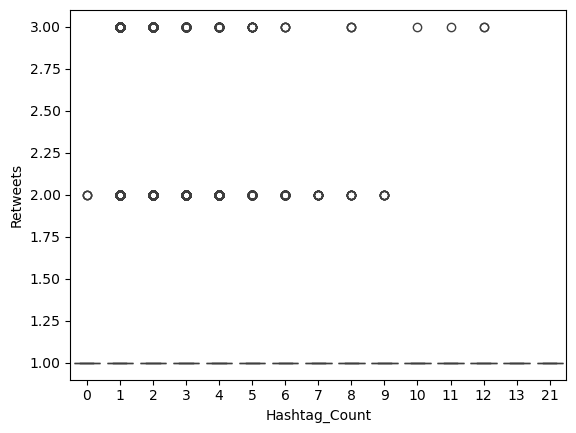

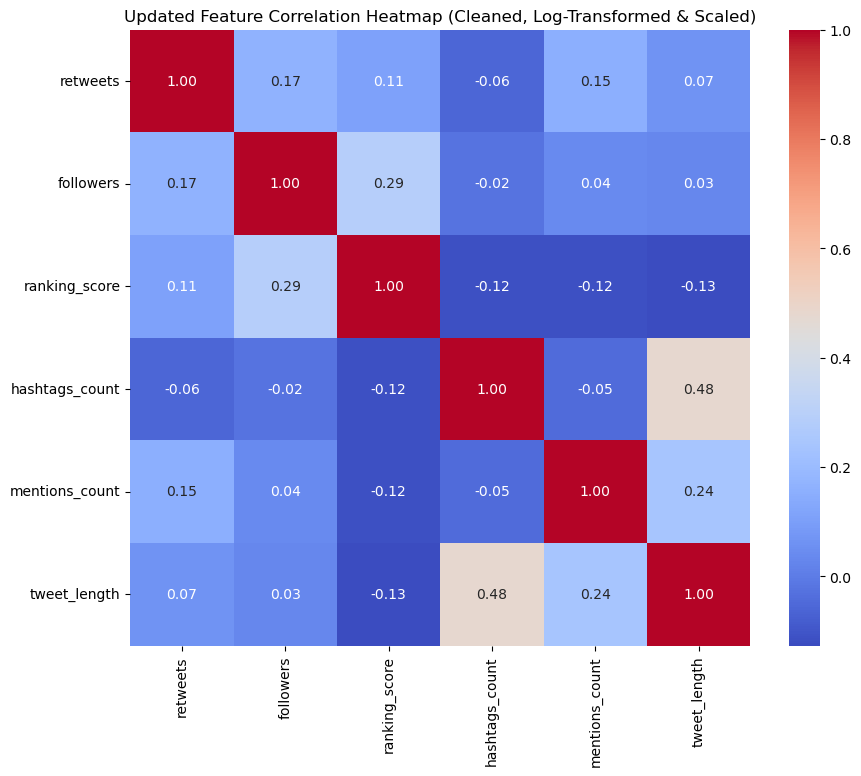

In [27]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Define the file path
file_path = "./ECE219_tweet_data/tweets_#gopatriots.txt"

# Initialize data storage
data = {
    "retweets": [],
    "followers": [],
    "ranking_score": [],
    "hashtags_count": [],
    "mentions_count": [],
    "tweet_length": []
}

# Read and extract features
with open(file_path, "r") as f:
    for line in f:
        tweet = json.loads(line.strip())

        # Extract standard features
        data["retweets"].append(tweet["metrics"]["citations"]["total"])
        data["followers"].append(tweet["author"]["followers"])
        data["ranking_score"].append(tweet["metrics"]["ranking_score"])

        # Extract additional features
        entities = tweet.get("tweet", {}).get("entities", {})
        data["hashtags_count"].append(len(entities.get("hashtags", [])))
        data["mentions_count"].append(len(entities.get("user_mentions", [])))
        data["tweet_length"].append(len(tweet.get("title", "")))

# Convert to DataFrame
df = pd.DataFrame(data)

# Remove Zero-Only Hashtags & Mentions
df_filtered = df[(df["hashtags_count"] > 0) | (df["mentions_count"] > 0)]

# Remove Extreme Outliers
for col in ["followers", "ranking_score", "retweets"]:
    upper_limit = df_filtered[col].quantile(0.99)
    lower_limit = df_filtered[col].quantile(0.01)
    df_filtered = df_filtered[(df_filtered[col] >= lower_limit) & (df_filtered[col] <= upper_limit)]

# Apply Log Transformation
for col in ["retweets", "followers", "ranking_score"]:
    df_filtered[col] = np.log1p(df_filtered[col])  # log(1 + x) prevents log(0) issues

# sandardize Only Predictor Features (NOT `retweets`)
features = ["followers", "ranking_score", "hashtags_count", "mentions_count", "tweet_length"]
scaler = StandardScaler()
df_filtered[features] = scaler.fit_transform(df_filtered[features])

# Plot Updated Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Updated Feature Correlation Heatmap (Cleaned, Log-Transformed & Scaled)")
plt.show()


Epoch 0: Train Loss = 0.4946, Test Loss = 0.4986
Epoch 20: Train Loss = 0.1275, Test Loss = 0.1228
Epoch 40: Train Loss = 0.0703, Test Loss = 0.0460
Epoch 60: Train Loss = 0.0584, Test Loss = 0.0381
Epoch 80: Train Loss = 0.0508, Test Loss = 0.0348
Epoch 100: Train Loss = 0.0471, Test Loss = 0.0327
Epoch 120: Train Loss = 0.0455, Test Loss = 0.0317
Epoch 140: Train Loss = 0.0430, Test Loss = 0.0311
Epoch 160: Train Loss = 0.0411, Test Loss = 0.0305
Epoch 180: Train Loss = 0.0396, Test Loss = 0.0301
Epoch 200: Train Loss = 0.0376, Test Loss = 0.0296
Epoch 220: Train Loss = 0.0375, Test Loss = 0.0293
Epoch 240: Train Loss = 0.0359, Test Loss = 0.0289
Epoch 260: Train Loss = 0.0348, Test Loss = 0.0286
Epoch 280: Train Loss = 0.0342, Test Loss = 0.0283
Epoch 300: Train Loss = 0.0333, Test Loss = 0.0280
Epoch 320: Train Loss = 0.0325, Test Loss = 0.0277
Epoch 340: Train Loss = 0.0318, Test Loss = 0.0274
Epoch 360: Train Loss = 0.0312, Test Loss = 0.0271
Epoch 380: Train Loss = 0.0306, Test 

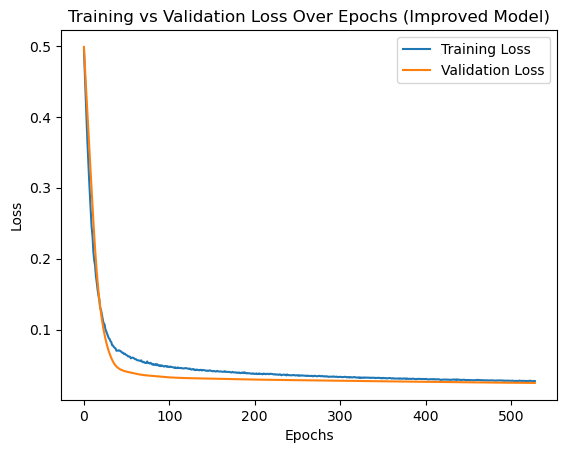

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# prepare data for training
X = df_filtered[features]
y = df_filtered["retweets"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to pytorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# define early stopping class
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.wait = 0  

    def check_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.wait = 0  
        else:
            self.wait += 1

        return self.wait >= self.patience  
    
# define mlp model with batchnorm & dropout
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)  
        self.dropout1 = nn.Dropout(0.1)  

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)  
        self.dropout2 = nn.Dropout(0.1)  

        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))  
        x = self.dropout2(x)
        x = self.fc3(x)  
        return x

# initialize model
input_dim = X_train.shape[1]
model = MLP(input_dim)

# loss & optimizer (faster learning rate initially)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)  

# learning rate scheduler (decays lr over time)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)  # decay lr slower

# train model & save best checkpoint
epochs = 700
early_stopping = EarlyStopping(patience=20)  
train_losses = []
test_losses = []
best_test_loss = float("inf")
best_model_path = "best_model_weights.pth"

for epoch in range(epochs):
    # forward pass
    model.train()
    y_pred_train = model(X_train_tensor)
    loss_train = criterion(y_pred_train, y_train_tensor)

    # backward pass
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # adjust learning rate
    if epoch > 500:  # apply lr decay after 500 epochs
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001  

    # compute validation loss
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        loss_test = criterion(y_pred_test, y_test_tensor)

    # store losses
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())

    # save best model based on lowest test loss
    if loss_test.item() < best_test_loss:
        best_test_loss = loss_test.item()
        torch.save(model.state_dict(), best_model_path)

    # print loss every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss_train.item():.4f}, Test Loss = {loss_test.item():.4f}")

    # early stopping check
    if early_stopping.check_stop(loss_test.item()):
        print(f"Early stopping at epoch {epoch}")
        break  

# load the best model for final evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# plot training vs validation loss
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Epochs (Improved Model)")
plt.legend()
plt.show()


In [81]:
# Compute Train-Test Loss Difference
train_loss_final = train_losses[-1]  # Last training loss value
test_loss_final = test_losses[-1]    # Last validation loss value
loss_gap = abs(train_loss_final - test_loss_final)

print(f"Final Training Loss: {train_loss_final:.4f}")
print(f"Final Test Loss: {test_loss_final:.4f}")
print(f"Train-Test Loss Gap: {loss_gap:.4f}")

if loss_gap > 0.05:
    print("Warning: Model is Overfitting! Consider increasing dropout or reducing model complexity.")
elif loss_gap < 0.01:
    print("Model is Well-Generalized! No overfitting detected.")
else:
    print("Model is slightly overfitting but still reasonable.")



Final Training Loss: 0.0276
Final Test Loss: 0.0249
Train-Test Loss Gap: 0.0026
Model is Well-Generalized! No overfitting detected.


In [85]:
import numpy as np
import pandas as pd
import torch

# Ensure features are in the correct order (same as training)
features = ["followers", "mentions_count", "tweet_length", "sentiment", "hour", "weekday"]

# Example: Raw input features for a new tweet
new_tweet = {
    "followers": 1200,         # Example: 1200 followers
    "mentions_count": 2,       # Example: 2 mentions
    "tweet_length": 140,       # Example: 140 characters long
    "sentiment": 0.5,          # Example: Positive sentiment
    "hour": 15,                # Example: Posted at 3 PM
    "weekday": 2               # Example: Posted on Tuesday
}

# Convert to DataFrame to match scaler's format
new_tweet_df = pd.DataFrame([new_tweet], columns=features)  # Keep column names

# Apply the trained scaler
new_tweet_scaled = scaler.transform(new_tweet_df)  # Standardize features without warnings

# Convert to tensor
new_tweet_tensor = torch.tensor(new_tweet_scaled, dtype=torch.float32)

# et model to evaluation mode to avoid BatchNorm errors
model.eval()

# Predict retweets
with torch.no_grad():  # Ensure gradients are not computed
    predicted_retweets = model(new_tweet_tensor).item()

print(f"Predicted Retweets: {predicted_retweets:.2f}")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- hour
- sentiment
- weekday
Feature names seen at fit time, yet now missing:
- hashtags_count
- ranking_score
